In [154]:
import numpy as np
import pandas as pd
import yfinance as yfc
import sklearn 
import csv
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler , OneHotEncoder
from sklearn.metrics import accuracy_score , mean_squared_error , mean_absolute_error , r2_score
from sklearn.linear_model import LinearRegression , Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
import talib as ta
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [111]:
# Чтение данных
df = pd.read_csv('/Users/cypinegor/Downloads/Telegram Desktop/Прошлые данные - SBER.csv')

# Переименование столбцов
d = {'Дата': 'DATE', 'Цена': 'CLOSE', 'Откр.': 'OPEN', 'Макс.': 'HIGH', 'Мин.': 'LOW', 'Объём': 'VOL', 'Изм. %': 'PRICE_DIFF'}
df = df.rename(columns=d)

# Преобразование даты
df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')

# Функция для конвертации строки в число с учетом формата VOL
def convert_vol(value):
    value = value.replace(',', '').strip()  # Убираем запятые и пробелы
    if 'B' in value:
        return float(value.replace('B', '')) * 1e9  # Умножаем на 1 миллиард
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6  # Умножаем на 1 миллион
    else:
        return float(value)  # Если нет приставки, просто конвертируем в число

# Преобразование значений в столбцах, где есть числа с запятой
df['CLOSE'] = df['CLOSE'].str.replace(',', '.').astype(float)
df['OPEN'] = df['OPEN'].str.replace(',', '.').astype(float)
df['HIGH'] = df['HIGH'].str.replace(',', '.').astype(float)
df['LOW'] = df['LOW'].str.replace(',', '.').astype(float)

# Применение функции для обработки столбца 'VOL'
df['VOL'] = df['VOL'].apply(convert_vol)

# Преобразование столбца 'PRICE_DIFF' в числовой формат от 0 до 1
df['PRICE_DIFF'] = df['PRICE_DIFF'].str.replace(',', '.').str.replace('%', '').astype(float) / 100

# Проверка результата
print(df.head(3))

df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month 
df['QUARTER'] = df['DATE'].dt.quarter  
df['SIN_MONTH'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['COS_MONTH'] = np.cos(2 * np.pi * df['MONTH'] / 12)
df = df.drop('DATE' , axis = 1)
df.head(3)
df = df[::-1].reset_index(drop=True)

# Применяем индикаторы с timeperiod=3
df['RSI'] = ta.RSI(df['CLOSE'], timeperiod=3)  # RSI за 3 периода
df['SMA'] = ta.SMA(df['CLOSE'], timeperiod=3)  # SMA за 3 периода
df['EMA'] = ta.EMA(df['CLOSE'], timeperiod=3)  # EMA за 3 периода
macd, macd_signal, macd_hist = ta.MACD(df['CLOSE'], fastperiod=3, slowperiod=3, signalperiod=3)  # MACD за 3 периода
df['MACD'] = macd
df['ATR'] = ta.ATR(df['HIGH'], df['LOW'], df['CLOSE'], timeperiod=3)  # ATR за 3 периода
df['MFI'] = ta.MFI(df['HIGH'], df['LOW'], df['CLOSE'], df['VOL'], timeperiod=3)  # MFI за 3 периода
df['CCI'] = ta.CCI(df['HIGH'], df['LOW'], df['CLOSE'], timeperiod=3)  # CCI за 3 периода

# Stochastic Oscillator с timeperiod=3
slowk, slowd = ta.STOCH(df['HIGH'], df['LOW'], df['CLOSE'], fastk_period=3, slowk_period=3, slowd_period=3)
df['Stochastic_K'] = slowk
df['Stochastic_D'] = slowd

# ADX с timeperiod=3
df['ADX'] = ta.ADX(df['HIGH'], df['LOW'], df['CLOSE'], timeperiod=3)  # ADX за 3 периода

# Добавляем лаговую переменную для CLOSE (сдвиг на +1 период)
df['CLOSE_lag+1'] = df['CLOSE'].shift(1)

# Инвертируем данные обратно, чтобы вернуть исходный порядок


# Выводим, сколько строк в данных после применения индикаторов
print(f"Количество строк после добавления индикаторов: {df.shape[0]}")
print(df.head(5))


        DATE   CLOSE    OPEN    HIGH     LOW           VOL  PRICE_DIFF
0 2025-04-01  307.80  310.50  320.26  275.76  1.230000e+11     -0.0062
1 2025-03-01  309.72  309.84  329.77  298.80  1.140000e+11      0.0003
2 2025-02-01  309.63  280.21  320.92  275.34  1.310000e+11      0.1029
Количество строк после добавления индикаторов: 184
   CLOSE   OPEN   HIGH    LOW           VOL  PRICE_DIFF  YEAR  MONTH  QUARTER  \
0  88.41  86.56  92.49  84.10  2.710000e+11      0.0569  2010      1        1   
1  76.30  87.60  89.80  73.23  4.020000e+11     -0.1370  2010      2        1   
2  85.80  77.00  90.92  76.71  4.760000e+11      0.1245  2010      3        1   
3  78.60  86.40  90.27  77.82  3.280000e+11     -0.0839  2010      4        2   
4  71.00  79.20  84.73  63.81  6.110000e+11     -0.0967  2010      5        2   

   SIN_MONTH  ...        SMA        EMA  MACD        ATR        MFI  \
0   0.500000  ...        NaN        NaN   NaN        NaN        NaN   
1   0.866025  ...        NaN        

In [113]:
imputer = KNNImputer(n_neighbors=5)

# Применяем импутер к DataFrame
df_1 = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [116]:
lagged_data = df_1.copy()

columns_to_lag = ['CLOSE', 'HIGH', 'LOW', 'VOL']
for col in columns_to_lag:
    lagged_data[f'{col}_lag_1'] = lagged_data[col].shift(1)
lagged_data = lagged_data.dropna(axis = 0 )


if 'DATE' in lagged_data.columns:
    lagged_data = lagged_data.drop('DATE', axis=1)
train_size = int(0.8 * len(lagged_data)) 
train_data = lagged_data[:train_size]
test_data = lagged_data[train_size:]
X_train = train_data.drop(columns=['CLOSE_lag+1']) 
y_train = train_data['CLOSE_lag+1']  

X_test = test_data.drop(columns=['CLOSE_lag+1']) 
y_test = test_data['CLOSE_lag+1']  

print(f"Размеры тренировочной выборки: X_train - {X_train.shape}, y_train - {y_train.shape}")
print(f"Размеры тестовой выборки: X_test - {X_test.shape}, y_test - {y_test.shape}")

Размеры тренировочной выборки: X_train - (146, 25), y_train - (146,)
Размеры тестовой выборки: X_test - (37, 25), y_test - (37,)


   OPEN   HIGH         SMA         EMA  CLOSE_lag_1  HIGH_lag_1  LOW_lag_1
1  87.6  89.80  127.888667  127.395722        88.41       92.49      84.10
2  77.0  90.92   83.503333   83.503333        76.30       89.80      73.23
3  86.4  90.27   80.233333   81.051667        85.80       90.92      76.71
4  79.2  84.73   78.466667   76.025833        78.60       90.27      77.82
5  70.4  84.56   75.366667   76.262917        71.00       84.73      63.81


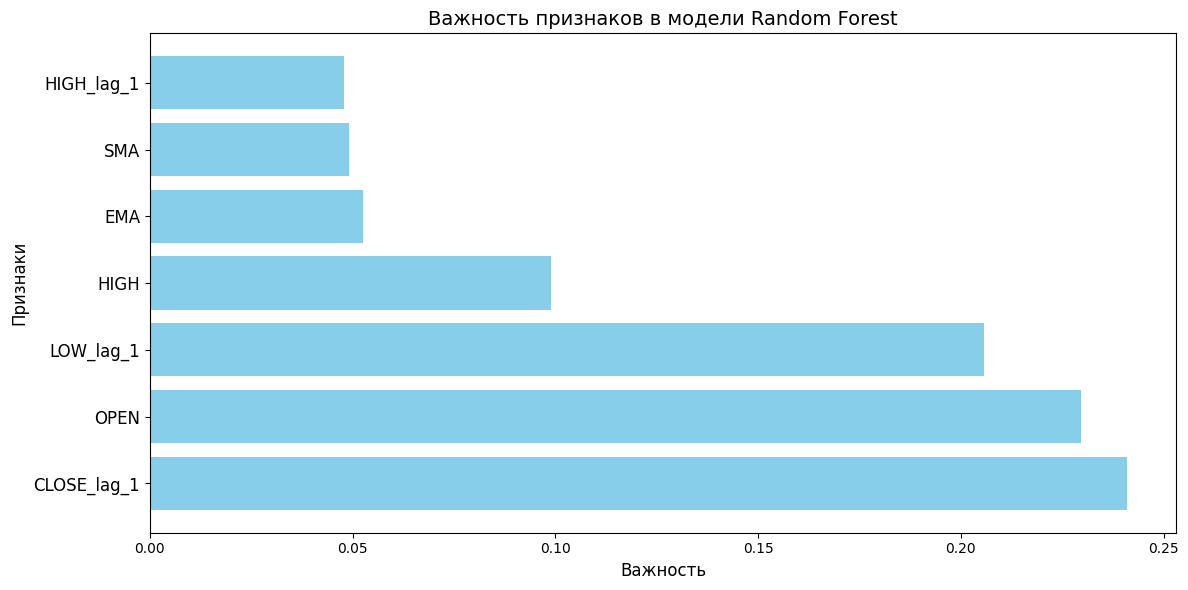

In [164]:
model = RandomForestRegressor()
model.fit(X_train, y_train)


importances = model.feature_importances_
threshold = np.mean(importances)
important_features = X_train.columns[importances > threshold]
X_train_important = X_train[important_features]
print(X_train_important.head())

importances_important = importances[X_train.columns.isin(important_features)]
sorted_indices = np.argsort(importances_important)[::-1]
sorted_features = important_features[sorted_indices]

plt.figure(figsize=(12, 6))
plt.title("Важность признаков в модели Random Forest", fontsize=14)
plt.barh(range(len(sorted_features)), importances_important[sorted_indices], align="center", color="skyblue")
plt.yticks(range(len(sorted_features)), sorted_features, fontsize=12)
plt.xlabel("Важность", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.tight_layout()
plt.show()

In [160]:
lagged_data_feat = lagged_data.drop('CLOSE_lag+1' , axis = 1)
numeric_cols = lagged_data_feat.select_dtypes(include=['number']).columns.tolist()
non_numeric_cols = lagged_data_feat.select_dtypes(exclude=['number']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols), 
        ('cat', OneHotEncoder(), non_numeric_cols)      ])

model_pipeline = Pipeline(steps=[
    # ('preprocessor', preprocessor),  # Применяем предобработку данных
    ('regressor', GradientBoostingRegressor(n_estimators=2000 , learning_rate=0.01 , max_depth= 3 ))
])


model_pipeline.fit(X_train_important, y_train) #X_train_important
y_pred = model_pipeline.predict(X_test[X_train_important.columns])  #X_test[X_train_important.columns]
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f'MSE на зафитчеванном град бустинге: {mse}')
print(f'MAE на зафитчеванном град бустинге: {mae}')


MSE на зафитчеванном град бустинге: 11.545611705607516
MAE на зафитчеванном град бустинге: 2.3843409647286533


In [161]:
y_pred[-1]

np.float64(310.78999932339804)

In [162]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

R²: 0.9975789278579322


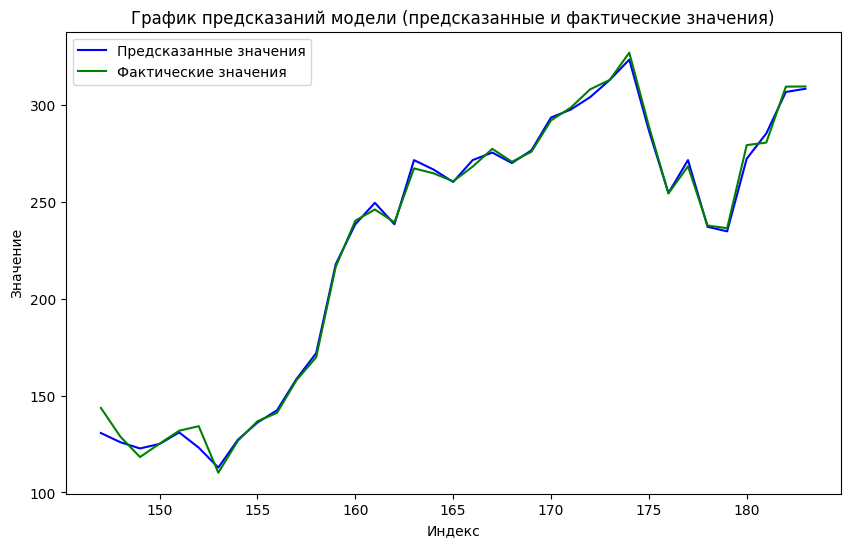

In [99]:
data_end = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
plt.figure(figsize=(10, 6))
sns.lineplot(x=data_end.index, y=data_end['y_pred'], color='b', label='Предсказанные значения')
sns.lineplot(x=data_end.index, y=data_end['y_test'], color='g', label='Фактические значения')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('График предсказаний модели (предсказанные и фактические значения)')
plt.legend()
plt.show()

In [329]:
print(lagged_data.columns.tolist())

['CLOSE', 'OPEN', 'HIGH', 'LOW', 'VOL', 'PRICE_DIFF', 'YEAR', 'MONTH', 'QUARTER', 'SIN_MONTH', 'COS_MONTH', 'RSI', 'SMA', 'EMA', 'MACD', 'ATR', 'MFI', 'CCI', 'Stochastic_K', 'Stochastic_D', 'ADX']


In [50]:
y_pred[-1]

np.float64(308.5338747531789)

In [ ]:
MSE на зафитчеванном рандомном лесе 9.474343414800657
MAE на зафитчеванном рандомном лесе 2.297587176619027